# Addessing failures from KNN Workshop - Improvement with SVM model
Sometimes the model just doesn't work. I thought I would share my failed attempts too since they might be interesting as well. Almost always people will only publish what works but that is of course not reality!

# Privacy Survey

**Why this dataset probably failed**

There is simply not enough correlation between the answers to the other questions and the one we are trying to predict. The pair plot shows way to much overlap.

## Data
We will use a dataset from the Open Government Portal. In this case, it's the "2022-23 Survey of Canadians on privacy-related issues" based on phone interviews ([Source](https://open.canada.ca/data/en/dataset/897a64fd-619d-48cc-b056-c9f6484b63b1)).

Suppose we want to classify our respondents based on the answers they give. KNN could be a good algorithm for this since the answers to the questions would hopefully put people in neat boxes as all the questions are somewhat related to each other.

KNN is a supervised learning algorithm though which means it needs to have labels to learn from. One approach is to have a bunch of group members label a bunch of the surveys manually and then have the rest of the surveys be classified by the KNN algorithm. It's a lot less work than labelling them all manually.

However, we don't want to go into that. Instead we'll just use one of the questions as a label. One of the questions is "In general, are you concerned about the protection of your privacy?". We want to predict the answer to this question based on the answers to all of the other questions. This is still useful because if you can predict this question with near-100% accuracy, then you don't really need to include this question in subsequent survey and thus make it shorter and more likely for people to complete.

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, hamming_loss
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
survey = pd.read_csv('../data/2022-23_survey_canadians_dataset.csv')
survey

,QUEST,STYPE,LANG,QF,Q1,Q2,Q3A,Q3B,Q4A,Q4B,...,Q20M1,Q20M2,Q20M3,Q21,Q22,Q23,Q24,AGE_COL,REGION,WEIGHT
0,228,2,EN,6,4,7,2,2,,2,...,2,,,2,2,1,4,3,3,1.470245
1,349,2,FR,5,1,5,5,5,4,,...,2,,,2,2,1,7,3,2,0.853297
2,1019,2,EN,5,2,7,5,5,6,,...,1,,,2,99,99,7,2,2,1.578553
3,1109,2,FR,5,1,7,7,7,,7,...,2,,,2,2,1,7,3,2,0.853297
4,1208,2,EN,10,2,7,6,6,,5,...,1,,,2,99,2,3,3,5,1.068920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,263855,1,EN,2,1,3,3,1,2,,...,1,,,2,2,2,1,4,1,0.378720
1496,263883,1,EN,2,1,7,4,4,4,,...,1,,,2,2,99,4,3,1,0.811720
1497,263889,1,EN,2,2,6,5,3,4,,...,1,,,2,2,2,2,4,1,0.378720
1498,263926,1,EN,2,2,7,4,4,,6,...,1,,,2,2,2,6,4,1,0.378720


This is extremely cryptic data. Fortunately, there is a data dictionary that comes with this data set. The question we want to predict is Q2. The answers range from 1 to 7 but other options are 98 (don't know) and 99 (refused). Let's drop those 98 and 99 responses.

In [3]:
survey = survey[survey['Q2'] <= 7]

Let's corrolate this with the answers from a bunch of other questions, for example:

* 3A. How would you rate your knowledge of your privacy rights?
* 3B. How would you rate your knowledge of how to protect your privacy rights?
* 4A. How much you agree or disagree with the following statements: I feel that businesses in general respect my privacy rights.How much you agree or disagree with the following statements: I feel that businesses in general respect my privacy rights.
* 4B. How much you agree or disagree with the following statements: I feel that the Government of Canada in general respects my privacy rights.
* 4C. How much you agree or disagree with the following statements: I am confident that I have enough information to know how new technologies might affect my personal privacy.
* 4D. Do you know what to do if you receive a notification from an organization about a privacy breach?

Looking closer at Q4A and Q4B by just looking at the table above, they seem to be mutually exclusive. Let's confirm that. Pandas lets you do boolean operations and with `sum` it will tell you the number of times `True` occurs.

In [4]:
sum((survey['Q4A'] != ' ') & (survey['Q4B'] != ' '))

0

So it looks like people got either question 4A or 4B but not both. The difference is that 4A asks about government and 4B asks about business. So what to do here?

We can merge them and assume people that people will trust governments and business in equal measure. Or we can create two separate data sets, one with government and one with business.

The one thing we cannot do is to just set it to zero because KNN will look at the nearest neighbours. This would just group people that didn't get 4A close to people that answered 1 on question 4B.

We'll go with the merging:

In [5]:
survey['Q4AB'] = (survey['Q4A'] + survey['Q4B']).astype('int')

/tmp/ipykernel_521541/2576484218.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survey['Q4AB'] = (survey['Q4A'] + survey['Q4B']).astype('int')


Let's get rid of the other "Don't know" and "Refused" answers

In [6]:
survey = survey[(survey['Q3A'] <= 7) & (survey['Q3B'] <= 7) & (survey['Q4AB'] <= 7) & (survey['Q4C'] <= 7) & (survey['Q4D'] <= 7)]

Let's look at the pairplot again to see if we can get similar patterns again that can be distinguished.

/localscratch/user1.17.0/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


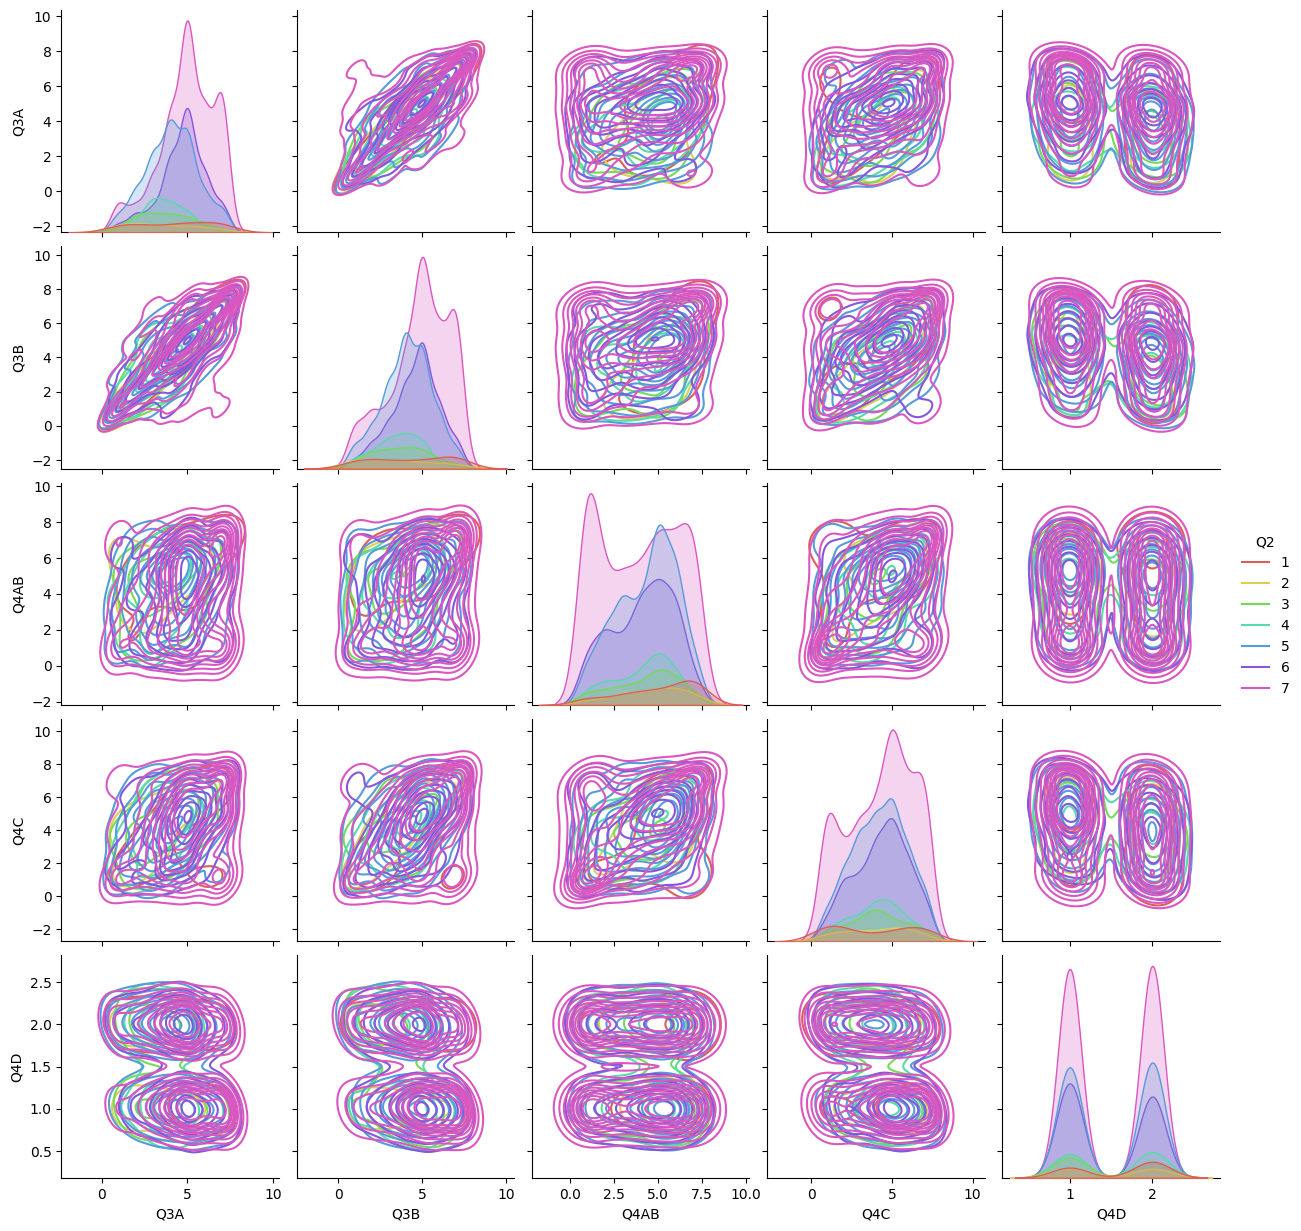

In [7]:
sns.pairplot(survey[['Q3A', 'Q3B', 'Q4AB', 'Q4C', 'Q4D', 'Q2']], hue='Q2', kind="kde", palette=sns.color_palette('hls',7))

Well, that does not look promising. There doesn't seem to be any relation. Just a tiny bit in Q3A and Q3B. Let's try it anyway and see what happens.

In [12]:
# import SVC classifier
from sklearn.svm import SVC
X = survey[['Q3A', 'Q3B', 'Q4AB', 'Q4C', 'Q4D']]
y = survey[['Q2']]

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.3)
neigh = SVC(kernel='rbf', C=9.0)
#neigh=SVC(kernel ='poly', degree = 8)
#KNeighborsClassifier(n_neighbors=7)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
accuracy_score(y_test, y_pred)

/localscratch/user1.17.0/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.4092741935483871

41%. KNN predicted with only a 33% accuracy which is not great! This tells us that the question "2. In general, are you concerned about the protection of your privacy?" does not really depend on the answers to the other questions that we picked.

In [9]:
X = survey[['Q3B']]
y = survey[['Q3A']]

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.3)
#neigh = KNeighborsClassifier(n_neighbors=7)
neigh = SVC(kernel='rbf', C=20.0)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
accuracy_score(y_test, y_pred)

/localscratch/user1.17.0/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5816532258064516

58% compared with 51% with KNN.

The kernel trick used with SVMs can help reduce the curse of dimensionality in high-dimensional spaces. Here's how:
- The curse of dimensionality refers to the exponential increase in volume associated with adding extra dimensions to a space. This makes data very sparse and difficult to model.
- By using a kernel, SVMs can map the data into a higher dimensional feature space without computing the coordinates explicitly.
- Common kernels like polynomial or Gaussian kernel allow modeling complex nonlinear decision boundaries.
- This provides a compact way to add higher order feature combinations that can capture meaningful patterns in the data.
- So even with large number of features, the kernel efficiently generates useful nonlinear features to avoid overfitting and improve generalization.
- This means SVMs can build good predictive models on high dimensional data where directly modeling all interactions between raw features would be infeasible.
- Regularization techniques used in SVMs also help avoid overfitting on high dimensional spaces.
So in summary, the kernel trick is a key advantage of SVMs that lets them scale effectively to high dimensions and learn robust decision boundaries from sparse data. This helps mitigate the curse of dimensionality. 

**Try improving the accuracy of the Books problem**

**Back to slides**